In [18]:
import tensorflow        as tf
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import mpltern
import os
import re

from tensorflow              import keras
from keras                   import layers
from tensorflow.keras.losses import Loss

print(f"tensorflow version = {tf.__version__}")

tensorflow version = 2.4.0


In [2]:
# get all the trimmed binodals
current_directory = os.getcwd()
all_files         = os.listdir(current_directory)
trimmed_files     = [file for file in all_files if (file.startswith("trim") and file.endswith(".binodal"))]

In [3]:
# go through all the trimmed files and get them as dataframes
the_output_binodals = []
for tfile in trimmed_files:
    df = pd.read_csv(tfile, sep='\|', names=["phi_s_top","phi_p_top","phi_c_top","phi_s_bot","phi_p_bot","phi_c_bot"], skiprows=1, engine='python')
    data = df.values.reshape(40000, 6)

    # convery to numpy object
    data = np.array(data, dtype=np.float64)
    the_output_binodals.append(data)
    
the_outputs = np.array(the_output_binodals)

In [4]:
# go through all the trimmed files and get the inputs as a vector
# this will be a vector that looks like [vs, vp, vc, chi_sc, chi_ps, chi_pc]

# define a regex that captures numerical, positive and negative, decimal values
pattern = r'(?:vs|vc|vp|chisc|chips|chipc)_([-+]?\d+\.\d+)'
the_inputs = []
for tstring in trimmed_files:
    
    # find all matches
    matches = re.findall(pattern, tstring)
    the_inputs.append(np.array(matches, dtype=np.float64))
    
the_inputs = np.array(the_inputs)

In [5]:
# tensorflowify everything
the_inputs  = tf.constant(the_inputs)
the_outputs = tf.constant(the_output_binodals)

print(f"Make sure these are equal: the number of inputs points is {the_inputs.shape[0]}, and number of outputs is {the_outputs.shape[0]}.")
if the_inputs.shape[0]==the_outputs.shape[0]:
    print ("They are equal! Moving on...")
else:
    print ("There is a problem. Exiting...")
    exit  ()

Make sure these are equal: the number of inputs points is 100, and number of outputs is 100.
They are equal! Moving on...


2023-09-14 22:23:54.953028: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
# get the total size of the dataset
total_samples    = the_inputs.shape[0]

# get the split
train_percentage = 0.8

# calculate the number of samples for training and testing
train_size = int(total_samples * train_percentage)
test_size  = total_samples - train_size

# create a tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices ((the_inputs, the_outputs))

# shuffle and split the dataset
dataset       = dataset.shuffle(total_samples, seed=42)
train_dataset = dataset.take(train_size)
test_dataset  = dataset.skip(train_size)

# split these into train_inputs, train_outputs, and test_inputs, test_outputs
# Assuming your dataset consists of (input, output) pairs
def map_func(input, output):
    return input, output

# Apply the map function to the training dataset to get train_inputs and train_outputs
train_dataset = train_dataset.map(map_func)

# Apply the map function to the test dataset to get test_inputs and test_outputs
test_dataset = test_dataset.map(map_func)

# Now, create separate lists or arrays for train_inputs, train_outputs, test_inputs, and test_outputs
train_inputs, train_outputs = [], []
test_inputs, test_outputs = [], []

for input, output in train_dataset:
    train_inputs.append(input)
    train_outputs.append(output)

for input, output in test_dataset:
    test_inputs.append(input)
    test_outputs.append(output)

# test_inputs   = tf.convert_to_tensor(test_inputs)
# test_outputs  = tf.convert_to_tensor(test_outputs)

# train_inputs  = tf.convert_to_tensor(train_inputs)
# train_outputs = tf.convert_to_tensor(train_outputs)

test_inputs   = np.array(test_inputs)
test_outputs  = np.array(test_outputs)
train_inputs  = np.array(train_inputs)
train_outputs = np.array(train_outputs)

In [7]:
# start creating the structure of the neural network
inputs = keras.Input(shape=(6,))
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(40000*6, activation="linear")(x)
outputs = layers.Reshape((40000, 6))(x)


In [8]:
# now that we have the skeleton of our neural network we need to define a custom loss function
# we will try to faithfully recreate the ones in the training set, but also 
# tack on the loss that comes with getting the chemical potentials wrong
mu_a = lambda phi_a, phi_b, phi_c, vs, vc, vp, chi_sc, chi_ps, chi_pc: tf.math.log(phi_a) + 1 - phi_a \
        - vs/vp * phi_b - vs/vc * (phi_c) + vs * (phi_b**2 * chi_ps + (phi_c)**2 * \
        chi_sc + phi_b * (phi_c) * (chi_ps + chi_sc - chi_pc) ) 

mu_b = lambda phi_a, phi_b, phi_c, vs, vc, vp, chi_sc, chi_ps, chi_pc: tf.math.log(phi_b) + 1 - phi_b \
        - vp/vs * phi_a - vp/vc * (phi_c) + vp * (phi_a**2 * chi_ps + (phi_c)**2 * \
        chi_pc + phi_a * (phi_c) * (chi_ps + chi_pc - chi_sc) )

mu_c = lambda phi_a, phi_b, phi_c, vs, vc, vp, chi_sc, chi_ps, chi_pc: tf.math.log(phi_c) + 1 - phi_c \
        - vc/vs * phi_a - vc/vp * phi_b + vc * (phi_a**2 * chi_sc + phi_b**2 * \
        chi_pc + phi_a * phi_b * (chi_sc + chi_pc - chi_ps) )

delta_mu_a = lambda pa1, pb1, pc1, pa2, pb2, pc2, vs, vc, vp, chi_sc, chi_ps, chi_pc: \
tf.math.abs(mu_a(pa1, pb1, pc1, vs, vc, vp, chi_sc, chi_ps, chi_pc) - \
mu_a(pa2, pb2, pc2, vs, vc, vp, chi_sc, chi_ps, chi_pc))

delta_mu_b = lambda pa1, pb1, pc1, pa2, pb2, pc2, vs, vc, vp, chi_sc, chi_ps, chi_pc: \
tf.math.abs(mu_b(pa1, pb1, pc1, vs, vc, vp, chi_sc, chi_ps, chi_pc) - \
mu_b(pa2, pb2, pc2, vs, vc, vp, chi_sc, chi_ps, chi_pc))

delta_mu_c = lambda pa1, pb1, pc1, pa2, pb2, pc2, vs, vc, vp, chi_sc, chi_ps, chi_pc: \
tf.math.abs(mu_c(pa1, pb1, pc1, vs, vc, vp, chi_sc, chi_ps, chi_pc) - \
mu_c(pa2, pb2, pc2, vs, vc, vp, chi_sc, chi_ps, chi_pc))

In [9]:
class MuLoss(Loss):
    def __init__(self, name="mu_loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        feature_inputs = inputs  # Access the input layer directly

        loss_dmu_a = tf.reduce_sum(tf.abs(delta_mu_a (y_pred[:, 0], y_pred[:,1], y_pred[:,2], y_pred[:,3], y_pred[:,4], y_pred[:,5], \
                                                      feature_inputs[0], feature_inputs[1], feature_inputs[2], feature_inputs[3], \
                                                      feature_inputs[4], feature_inputs[5])))
        
        loss_dmu_b = tf.reduce_sum(tf.abs(delta_mu_b (y_pred[:, 0], y_pred[:,1], y_pred[:,2], y_pred[:,3], y_pred[:,4], y_pred[:,5], \
                                                      feature_inputs[0], feature_inputs[1], feature_inputs[2], feature_inputs[3], \
                                                      feature_inputs[4], feature_inputs[5])))

        loss_dmu_c = tf.reduce_sum(tf.abs(delta_mu_c (y_pred[:, 0], y_pred[:,1], y_pred[:,2], y_pred[:,3], y_pred[:,4], y_pred[:,5], \
                                                      feature_inputs[0], feature_inputs[1], feature_inputs[2], feature_inputs[3], \
                                                      feature_inputs[4], feature_inputs[5])))

        mu_loss  = loss_dmu_a + loss_dmu_b + loss_dmu_c
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

        loss     = mu_loss + mse_loss
        return float(loss)

In [10]:
# set up the inputs and outputs
model = keras.Model(inputs=inputs, outputs=outputs)

In [11]:
# compile the thing before we can fit things to it
model.compile (optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanSquaredError()])

In [12]:
# allow it to fit
history = model.fit(train_inputs, train_outputs, epochs=500, validation_split=0.1)

2023-09-14 22:24:00.031455: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/500
3/3 [==============================] - 3s 612ms/step - loss: 0.1595 - mean_squared_error: 0.1595 - val_loss: 0.0940 - val_mean_squared_error: 0.0940
Epoch 2/500
3/3 [==============================] - 1s 338ms/step - loss: 0.0876 - mean_squared_error: 0.0876 - val_loss: 0.0364 - val_mean_squared_error: 0.0364
Epoch 3/500
3/3 [==============================] - 1s 416ms/step - loss: 0.0383 - mean_squared_error: 0.0383 - val_loss: 0.0461 - val_mean_squared_error: 0.0461
Epoch 4/500
3/3 [==============================] - 1s 422ms/step - loss: 0.0481 - mean_squared_error: 0.0481 - val_loss: 0.0293 - val_mean_squared_error: 0.0293
Epoch 5/500
3/3 [==============================] - 1s 412ms/step - loss: 0.0256 - mean_squared_error: 0.0256 - val_loss: 0.0211 - val_mean_squared_error: 0.0211
Epoch 6/500
3/3 [==============================] - 2s 677ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.0189 - val_mean_squared_error: 0.0189
Epoch 7/500
3/3 [=================

3/3 [==============================] - 1s 317ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 52/500
3/3 [==============================] - 1s 307ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 53/500
3/3 [==============================] - 1s 299ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 54/500
3/3 [==============================] - 1s 312ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 55/500
3/3 [==============================] - 1s 351ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 56/500
3/3 [==============================] - 1s 275ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 57/500
3/3 [=======================

Epoch 102/500
3/3 [==============================] - 1s 400ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 103/500
3/3 [==============================] - 1s 360ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 104/500
3/3 [==============================] - 1s 399ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 105/500
3/3 [==============================] - 1s 350ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 106/500
3/3 [==============================] - 1s 365ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 107/500
3/3 [==============================] - 1s 326ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 108/500
3/3 [===

3/3 [==============================] - 1s 338ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 153/500
3/3 [==============================] - 2s 643ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 154/500
3/3 [==============================] - 1s 363ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 155/500
3/3 [==============================] - 1s 385ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 156/500
3/3 [==============================] - 1s 341ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 157/500
3/3 [==============================] - 1s 317ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 158/500
3/3 [=================

3/3 [==============================] - 1s 383ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 203/500
3/3 [==============================] - 1s 363ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 204/500
3/3 [==============================] - 1s 378ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 205/500
3/3 [==============================] - 2s 450ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 206/500
3/3 [==============================] - 1s 450ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 207/500
3/3 [==============================] - 2s 522ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 208/500
3/3 [=================

3/3 [==============================] - 1s 346ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 253/500
3/3 [==============================] - 2s 442ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 254/500
3/3 [==============================] - 1s 340ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 255/500
3/3 [==============================] - 1s 359ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 256/500
3/3 [==============================] - 1s 348ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 257/500
3/3 [==============================] - 1s 337ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 258/500
3/3 [=================

3/3 [==============================] - 1s 441ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 303/500
3/3 [==============================] - 1s 409ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 304/500
3/3 [==============================] - 1s 408ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 305/500
3/3 [==============================] - 1s 373ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 306/500
3/3 [==============================] - 1s 331ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 307/500
3/3 [==============================] - 2s 521ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 308/500
3/3 [=================

3/3 [==============================] - 1s 412ms/step - loss: 8.2026e-04 - mean_squared_error: 8.2026e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 352/500
3/3 [==============================] - 2s 537ms/step - loss: 8.6268e-04 - mean_squared_error: 8.6268e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 353/500
3/3 [==============================] - 2s 486ms/step - loss: 8.6866e-04 - mean_squared_error: 8.6866e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 354/500
3/3 [==============================] - 1s 482ms/step - loss: 7.9398e-04 - mean_squared_error: 7.9398e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 355/500
3/3 [==============================] - 1s 354ms/step - loss: 8.0411e-04 - mean_squared_error: 8.0411e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 356/500
3/3 [==============================] - 1s 354ms/step - loss: 8.9256e-04 - mean_squared_error: 8.9256e-04 - val_loss: 0.0034 - val_mean_squared_er

3/3 [==============================] - 1s 439ms/step - loss: 6.6226e-04 - mean_squared_error: 6.6226e-04 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 400/500
3/3 [==============================] - 1s 386ms/step - loss: 6.7549e-04 - mean_squared_error: 6.7549e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 401/500
3/3 [==============================] - 1s 369ms/step - loss: 5.6409e-04 - mean_squared_error: 5.6409e-04 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 402/500
3/3 [==============================] - 1s 353ms/step - loss: 6.8533e-04 - mean_squared_error: 6.8533e-04 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 403/500
3/3 [==============================] - 1s 393ms/step - loss: 6.2920e-04 - mean_squared_error: 6.2920e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 404/500
3/3 [==============================] - 1s 415ms/step - loss: 5.8567e-04 - mean_squared_error: 5.8567e-04 - val_loss: 0.0030 - val_mean_squared_er

Epoch 447/500
3/3 [==============================] - 1s 351ms/step - loss: 4.6819e-04 - mean_squared_error: 4.6819e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 448/500
3/3 [==============================] - 1s 344ms/step - loss: 5.6863e-04 - mean_squared_error: 5.6863e-04 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 449/500
3/3 [==============================] - 2s 562ms/step - loss: 5.4515e-04 - mean_squared_error: 5.4515e-04 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 450/500
3/3 [==============================] - 1s 388ms/step - loss: 5.1032e-04 - mean_squared_error: 5.1032e-04 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 451/500
3/3 [==============================] - 1s 367ms/step - loss: 5.3066e-04 - mean_squared_error: 5.3066e-04 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 452/500
3/3 [==============================] - 1s 354ms/step - loss: 4.9343e-04 - mean_squared_error: 4.9343e-04 - val_loss: 0.0022 - val_m

Epoch 495/500
3/3 [==============================] - 1s 359ms/step - loss: 4.8476e-04 - mean_squared_error: 4.8476e-04 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 496/500
3/3 [==============================] - 1s 340ms/step - loss: 5.4968e-04 - mean_squared_error: 5.4968e-04 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 497/500
3/3 [==============================] - 1s 351ms/step - loss: 5.1154e-04 - mean_squared_error: 5.1154e-04 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 498/500
3/3 [==============================] - 1s 347ms/step - loss: 4.8712e-04 - mean_squared_error: 4.8712e-04 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 499/500
3/3 [==============================] - 1s 335ms/step - loss: 4.8646e-04 - mean_squared_error: 4.8646e-04 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 500/500
3/3 [==============================] - 1s 334ms/step - loss: 5.2629e-04 - mean_squared_error: 5.2629e-04 - val_loss: 0.0025 - val_m

In [13]:
history.history

{'loss': [0.15525057911872864,
  0.08287760615348816,
  0.03904952108860016,
  0.046829815953969955,
  0.024941401556134224,
  0.018948085606098175,
  0.017662884667515755,
  0.012988658621907234,
  0.0113406116142869,
  0.012035117484629154,
  0.009703444316983223,
  0.007816911675035954,
  0.008197358809411526,
  0.00798659399151802,
  0.0071746716275811195,
  0.006949039176106453,
  0.006611301098018885,
  0.006374432239681482,
  0.006431652698665857,
  0.006292298436164856,
  0.006179494317620993,
  0.00619558384642005,
  0.006074860226362944,
  0.0059900362975895405,
  0.0059661539271473885,
  0.005945032462477684,
  0.005852686241269112,
  0.0058387648314237595,
  0.005804919637739658,
  0.0057570417411625385,
  0.0057244012132287025,
  0.0056707244366407394,
  0.005786571651697159,
  0.005595479626208544,
  0.005557432770729065,
  0.005576256662607193,
  0.005519285332411528,
  0.005492290016263723,
  0.005523103754967451,
  0.005331616848707199,
  0.0054097785614430904,
  0.005

In [14]:
results = model.evaluate(test_inputs, test_outputs, batch_size=16)

2/2 [==============================] - 0s 75ms/step - loss: 8.1580e-04 - mean_squared_error: 8.1580e-04


In [32]:
some_input  = np.array([[1, 1, 2, 0, -11, -1]])
some_output = model.predict(some_input)

/var/folders/ph/ct_dywfx0d9278v4m3krtdtw0000gn/T/ipykernel_35504/3841010748.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


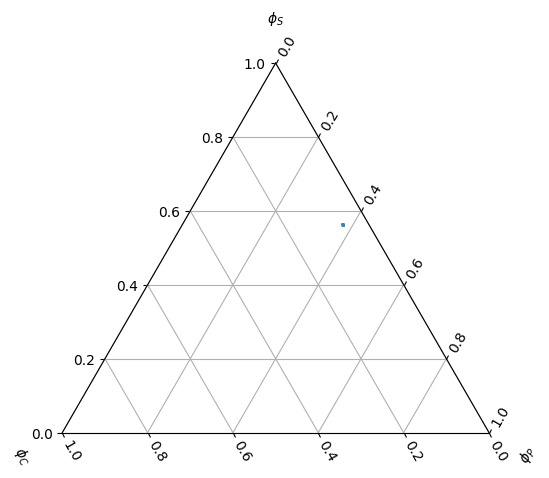

In [33]:
fig = plt.figure()
ax  = fig.add_subplot(projection="ternary")
ax.scatter (some_output[:,0], some_output[:,2], some_output[:,1], color='springgreen'  , s=1)
ax.scatter (some_output[:,3], some_output[:,5], some_output[:,4], color='steelblue', s=1)
ax.set_tlabel("$\\phi _{S}$")
ax.set_llabel("$\\phi _{C}$")
ax.set_rlabel("$\\phi _{P}$")
ax.set_tlim(0,1)
ax.set_llim(0,1)
ax.set_rlim(0,1)
positions = ["tick1", "tick2"]
for position in positions:
    ax.taxis.set_ticks_position(position)
    ax.laxis.set_ticks_position(position)
    ax.raxis.set_ticks_position(position)
ax.grid ()
fig.show()

In [29]:
inputs

<KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'input_1')>

In [31]:
train_inputs

array([[  1.,   1.,   2.,   0., -11.,  -1.],
       [  1.,   7.,   2., -12.,  -1.,  -1.],
       [  1.,   1.,   8.,   0., -11.,  -1.],
       [  1.,   7.,   2., -12.,  -3.,  -1.],
       [  1.,   8.,   2., -11.,  -1.,  -1.],
       [  1.,   6.,   2., -10.,  -2.,  -1.],
       [  1.,   6.,   2., -11.,  -2.,  -1.],
       [ 10.,   1.,   1.,  -1.,  -2., -11.],
       [  1.,   1.,  10., -12.,  -1.,  -1.],
       [  1.,   4.,   2., -12.,  -2.,  -1.],
       [  1.,   1.,  10.,  -9.,  -1.,  -1.],
       [  1.,   4.,   2., -11.,  -2.,  -1.],
       [  1.,   1.,   4., -10.,  -1.,  -1.],
       [  1.,   4.,   2., -10.,  -1.,  -1.],
       [ 10.,   1.,   1.,  -1.,  -2., -12.],
       [  1.,   6.,   2., -12.,  -3.,  -1.],
       [  1.,   7.,   2., -10.,  -1.,  -1.],
       [  1.,   9.,   2., -11.,  -2.,  -1.],
       [  1.,   1.,   6., -11.,  -1.,  -1.],
       [  1.,   1.,   6., -12.,  -1.,  -1.],
       [  1.,   4.,   2., -12.,  -3.,  -1.],
       [  1.,   7.,   2., -10.,  -2.,  -1.],
       [  

In [34]:
the_inputs

<tf.Tensor: shape=(100, 6), dtype=float64, numpy=
array([[  1.,   1.,  10.,   0.,  -9.,  -1.],
       [  1.,   4.,   2., -11.,  -1.,  -1.],
       [  1.,   9.,   2.,  -9.,  -1.,  -1.],
       [  1.,   8.,   2., -10.,  -1.,  -1.],
       [  1.,   7.,   2., -10.,  -2.,  -1.],
       [  1.,   1.,   6., -12.,  -1.,  -1.],
       [  1.,   5.,   2., -12.,  -2.,  -1.],
       [  8.,   1.,   1.,  -1.,  -2., -11.],
       [  1.,   1.,  10., -12.,  -1.,  -1.],
       [  1.,   8.,   2., -12.,  -3.,  -1.],
       [  1.,   1.,   2., -10.,  -1.,  -1.],
       [  1.,   8.,   2.,  -9.,  -1.,  -1.],
       [  1.,   1.,   8.,   0., -10.,  -1.],
       [  1.,   1.,   8., -10.,  -1.,  -1.],
       [  1.,   4.,   2., -10.,  -2.,  -1.],
       [  1.,   1.,   2.,   0., -10.,  -1.],
       [  1.,   1.,  10.,  -8.,  -1.,  -1.],
       [  1.,   7.,   2., -11.,  -1.,  -1.],
       [  1.,   1.,  10.,   0., -11.,  -1.],
       [  1.,   8.,   2., -11.,  -2.,  -1.],
       [  1.,   6.,   2., -12.,  -2.,  -1.],
     

In [38]:
np_inputs  = np.array(the_inputs )
np_outputs = np.array(the_outputs)

/var/folders/ph/ct_dywfx0d9278v4m3krtdtw0000gn/T/ipykernel_35504/2478843653.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


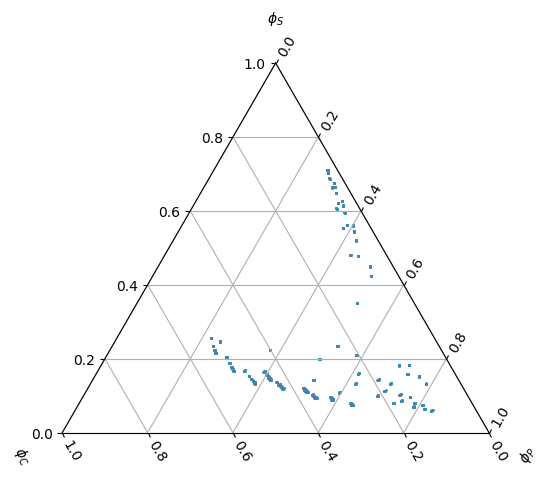

In [41]:
np_inputs[0]
fig = plt.figure()
ax  = fig.add_subplot(projection="ternary")
ax.scatter (np_outputs[:,0], np_outputs[:,2], np_outputs[:,1], color='springgreen'  , s=1)
ax.scatter (np_outputs[:,3], np_outputs[:,5], np_outputs[:,4], color='steelblue', s=1)
ax.set_tlabel("$\\phi _{S}$")
ax.set_llabel("$\\phi _{C}$")
ax.set_rlabel("$\\phi _{P}$")
ax.set_tlim(0,1)
ax.set_llim(0,1)
ax.set_rlim(0,1)
positions = ["tick1", "tick2"]
for position in positions:
    ax.taxis.set_ticks_position(position)
    ax.laxis.set_ticks_position(position)
    ax.raxis.set_ticks_position(position)
ax.grid ()
fig.show()

In [43]:
df = pd.read_csv("trim.vs_1.0-vc_1.0-vp_10.0-chisc_0.0-chips_-9.0-chipc_-1.0.binodal", sep='\|', names=["phi_s_top","phi_p_top","phi_c_top","phi_s_bot","phi_p_bot","phi_c_bot"], skiprows=1, engine='python')
data = df.values.reshape(40000, 6)

# convery to numpy object
data = np.array(data, dtype=np.float64)

FileNotFoundError: [Errno 2] No such file or directory: 'trim.vs_1.0-vc_1.0-vp_10.0-chisc_0.0-chips_-9.0-chipc_-1.0.binodal'